# <font style="color:blue">Project 4: Kaggle Competition - Semantic Segmentation</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>1.1. Dataset Class</h3></td> <td><h3>7</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>1.2. Visualize dataset</h3></td> <td><h3>3</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>2. Evaluation Metrics</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>3. Model</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>4.1. Train</h3></td> <td><h3>7</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>4.2. Inference</h3></td> <td><h3>3</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>5. Prepare Submission CSV</h3></td><td><h3>10</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>6. Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>

---

**In this project, you have participated in the Kaggle competition, and also submit the notebook and othe code in the course lab.**

**This Kaggle competition is a semantic segmentation challenge.**

<h2>Dataset Description </h2>
<p>The dataset consists of 3,269 images in 12 classes (including background). All images were taken from drones in a variety of scales. Samples are shown below:
<img src="https://github.com/ishann/aeroscapes/blob/master/assets/data_montage.png?raw=true" width="800" height="800">
<p>The data was splitted into public train set and private test set which is used for evaluation of submissions. You can split public subset into train and validation sets yourself.
Images are named with a unique <code>ImageId</code>. </p>
<p> You should segment and classify the images in the test set.</p>
<p>The dataset consists of landscape images taken from drones in a variety of scales.</p>

**The notebook is divided into sections. You have to write code, as mention in the section.  For other helper functions, you can write `.py` files and import them in the notebook. You have to submit the notebook along with `.py` files. Your submitted code must be runnable without any bug.**

# <font style="color:green">0. Import Packages and Data Constants</font>

In this section, import necessary packages and define data constants those will be in the project

## <font style="color:green">0.1. Import Packages</font>

In this subjection, import the necessary packages


In [1]:
''' 
    Check which Python environemnt is running, by default in the CONDA base 
    To change to correct path, install the jupyterlab in the current CONDA
    environment.
    
'''
import sys
print('INFO: System executable path = ', sys.executable)

INFO: System executable path =  /home/prem/projects/dl_ml_ai/semantic_segmentation/env/bin/python3.7


In [2]:
# Import Matplotlib and the plots in the notebook
import matplotlib.pyplot as plt # pylint: disable=unused-import
%matplotlib inline

In [3]:
# Import os for paths joining and other purposes
# Import time for displaying the time for each epoch 
import os
import time

In [4]:
# Import number python for libear algebra and quick processing 
import numpy as np 
# Import Data Processing, CSV file I/O 
import pandas as pd 
# Import collections
import collections

from collections import defaultdict

In [5]:
# opencv library
import cv2

In [6]:
from PIL import Image

In [7]:
# pytorch imports
import torch
# import primitives to build our custom model
import torch.nn as nn
# optimizer
import torch.optim as optim


# some extended pytorch primitives
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import MultiStepLR


In [8]:
# model zoo with pretrained models
import torchvision.models as models
from torchvision import transforms
import torchvision.transforms.functional as TF
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

In [9]:
# Import Dataclass
from dataclasses import dataclass

In [10]:
# Import scikit learn (science kit learn)
from sklearn.model_selection import train_test_split

In [11]:
print('INFO: Torch Version is ', torch.__version__)
print('INFO: Torch CUDA Version is ', torch.version.cuda)

INFO: Torch Version is  1.5.0
INFO: Torch CUDA Version is  10.2


In [12]:
def is_cuda_device():
    if (torch.cuda.is_available()):
        return True
    else:
        return False


In [13]:
if (is_cuda_device):
    print("INFO: GPU avaible")
else:
    print("INFO: GPU is not available") 

INFO: GPU avaible


In [14]:
# Define data contants as a class, DataConfiguration
@dataclass
class DataConfiguration:
    input_data: str = 'data/input'
    images_data: str = 'imgs'
    masks_data: str = 'masks'        
    output_data: str = 'data/output'
    train_file_name: str = 'train.csv'
    test_file_name: str = 'test.csv'    
    submission_file_name: str = 'submission.csv'
    split_ratio: int = 0.8
    model_dir: str = 'models'
    model_file_name: str = 'semantic_sementation.pt'
    image_re_size_width: int = 360
    image_re_size_height: int = 640        
    image_crop_size: int = 512
    num_classes: int = 12
    batch_size: int = 10 

In [15]:
# Instance of the DataConfiguration        
data_config = DataConfiguration()

In [16]:
def create_models_dir():
    model_dir = data_config.model_dir
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

In [17]:
model_path = data_config.model_dir
create_models_dir()

In [18]:
# Get the train file name
def get_train_file_name():
    file_name = os.path.join(data_config.input_data,
                             data_config.train_file_name) 
    return file_name

In [19]:
# Get the test file name
def get_test_file_name():
    file_name = os.path.join(data_config.input_data,
                             data_config.test_file_name)
    return file_name

In [20]:
train_file_name = get_train_file_name()
print("INFO: Train and Validation File Name: ", train_file_name)

test_file_name = get_test_file_name()
print("INFO: Test File Name: ", test_file_name)

INFO: Train and Validation File Name:  data/input/train.csv
INFO: Test File Name:  data/input/test.csv


# <font style="color:green">1. Data Exploration</font>

In this section, you have to write your custom dataset class and visualize a few images (max five images) and its mask.

## <font style="color:green">1.1. Dataset Class [7 Points]</font>

**In this sub-section, write your custom dataset class.**


**Note that there are not separate validation data, so you will have to create your validation set by dividing train data into train and validation data. Usually, in practice, we do `80:20` ratio for train and validation, respectively.** 

**for example:**

```
class SemSegDataset(Dataset):
    """ Generic Dataset class for semantic segmentation datasets.

        Arguments:
            data_path (string): Path to the dataset folder.
            images_folder (string): Name of the folder containing the images (related to the data_path).
            masks_folder (string): Name of the folder containing the masks (related to the data_path).
            csv_path (string): train or test csv file name
            image_ids (list): List of images.
            train_val_test (string): 'train', 'val' or 'test'
            transforms (callable, optional): A function/transform that inputs a sample
                and returns its transformed version.
            class_names (list, optional): Names of the classes.
            

        Dataset folder structure:
            Folder containing the dataset should look like:
            - data_path
            -- images_folder
            -- masks_folder

            Names of images in the images_folder and masks_folder should be the same for same samples.
    """
```

In [21]:
# Get the data frame
def get_df(file_name):
    df = pd.read_csv(file_name)
    return df

In [22]:
# Get the training data frmae
train_valid_df = get_df(train_file_name)

print("INFO: Number of Training and Validation Samples = ",
         len(train_valid_df))
#print(train_valid_df)

INFO: Number of Training and Validation Samples =  2621


In [23]:
train_df, valid_df = train_test_split(train_valid_df, 
                                      train_size = data_config.split_ratio,
                                      random_state = 42)
                                           
print('INFO: Training Size = {}, Validation Size = {}'
      .format(len(train_df), len(valid_df)))

INFO: Training Size = 2096, Validation Size = 525


In [24]:
# Get the Test data
test_df = get_df(test_file_name)
print("INFO: The Number of test samples = ", len(test_df))

INFO: The Number of test samples =  648


In [25]:
# Image data path
images_data = os.path.join(data_config.input_data,
                           data_config.images_data, '')
print("INFO: Images data path = ", images_data)

INFO: Images data path =  data/input/imgs/


In [26]:
# Image data path
masks_data = os.path.join(data_config.input_data,
                           data_config.masks_data, '')
print("INFO: Masks data path = ", masks_data)

INFO: Masks data path =  data/input/masks/


In [27]:
# Mean and standard deviation for resnet
mean = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]

In [28]:
def valid_image_transforms(): 
    transform = transforms.Compose([
                            transforms.Resize(data_config.image_re_size_width, 
                                              data_config.image_re_size_height),
                            transforms.ToTensor(),
                            transforms.Normalize(mean, std)
                    ])    

In [29]:
def valid_mask_transforms(): 
    transform = transforms.Compose([
                            transforms.Resize(data_config.image_re_size_width, 
                                              data_config.image_re_size_height)                            
                    ])    

In [30]:
def test_image_transforms(): 
    transform = transforms.Compose([                            
                            transforms.ToTensor(),
                            transforms.Normalize(mean, std)
                    ])  

In [31]:
import random
def train_transforms(image, mask):
        # Resize
        resize = transforms.Resize(size = (data_config.image_re_size_width, 
                                  data_config.image_re_size_height))
        image = resize(image)
        mask = resize(mask)
        
        #color jitter
        color_jitter = transforms.ColorJitter(hue=.05, saturation=.05)
        image = color_jitter(image)
        mask = color_jitter(mask)

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Transform to tensor
        image = TF.to_tensor(image)        
        
        norm = transforms.Normalize(mean, std)
        image = norm(image)
        
        return image, torch.from_numpy(np.asarray(mask))

In [45]:
class SegmentDataset(Dataset):
    def __init__(self, df, images_path, train_valid_test, masks_path = None):
        self.df = df
        self.images_path = images_path
        self.train_valid_test = train_valid_test
        self.masks_path = masks_path
        self.valid_image_transforms = transforms.Compose([
                            transforms.Resize(size = (data_config.image_re_size_width, 
                                              data_config.image_re_size_height)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean, std)
                            ])
        self.valid_mask_transforms = transforms.Compose([
                            transforms.Resize(size = (data_config.image_re_size_width, 
                                              data_config.image_re_size_height))
        ])
        self.test_image_transforms = transforms.Compose([                            
                            transforms.ToTensor(),
                            transforms.Normalize(mean, std)
        ])
        
    # get dataset's length
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if self.train_valid_test == "test":
            img_path = self.images_path + str(self.df.iloc[idx, 0]) + '.jpg'
            img = Image.open(img_path)
            img = self.test_image_transforms(img)
            return img_path, img
        elif self.train_valid_test == "train":
            img_path = self.images_path + str(self.df.iloc[idx, 0]) + '.jpg'
            mask_path = self.masks_path + str(self.df.iloc[idx, 0]) + '.png'
            img = Image.open(img_path)
            mask = Image.open(mask_path)
            img,mask = train_transforms(img, mask)
            return img, mask
        else:#valid
            img_path = self.images_path + str(self.df.iloc[idx, 0]) + '.jpg'
            mask_path = self.masks_path + str(self.df.iloc[idx, 0]) + '.png'
            img = Image.open(img_path)
            mask = Image.open(mask_path)
            img = self.valid_image_transforms(img)
            mask = self.valid_mask_transforms(mask)
            return img, torch.from_numpy(np.asarray(mask))

In [46]:
train_dataset = SegmentDataset(df = train_df, 
                               images_path = images_data, 
                               train_valid_test = 'train',
                               masks_path = masks_data) 
valid_dataset = SegmentDataset(df = valid_df, 
                               images_path = images_data, 
                               train_valid_test = 'valid',
                               masks_path = masks_data) 

In [47]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size = data_config.batch_size,
                                           shuffle = True, 
                                           num_workers = 4,
                                           drop_last = True )

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                           batch_size = data_config.batch_size, 
                                           shuffle = False,
                                           num_workers = 4,
                                           drop_last = True )

data_loaders = {'train': train_loader, 'val': valid_loader}

In [48]:
img1, msk1 = train_dataset.__getitem__(100)
img2, msk2 = train_dataset.__getitem__(200)
img3, msk3 = train_dataset.__getitem__(400)
img4, msk4 = valid_dataset.__getitem__(100)

msk4.shape

torch.Size([360, 640])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


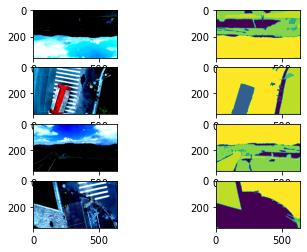

In [54]:
plt.figure()
plt.subplot(4,2,1)
plt.imshow(np.transpose(img1,(1,2,0)))
plt.subplot(4,2,3)
plt.imshow(np.transpose(img2,(1,2,0)))
plt.subplot(4,2,5)
plt.imshow(np.transpose(img3,(1,2,0)))
plt.subplot(4,2,7)
plt.imshow(np.transpose(img4,(1,2,0)))


plt.subplot(4,2,2)
plt.imshow(np.reshape(msk1,(data_config.image_re_size_width, 
                                              data_config.image_re_size_height)))
plt.subplot(4,2,4)
plt.imshow(np.reshape(msk2,(data_config.image_re_size_width, 
                                              data_config.image_re_size_height)))
plt.subplot(4,2,6)
plt.imshow(np.reshape(msk3,(data_config.image_re_size_width, 
                                              data_config.image_re_size_height)))
plt.subplot(4,2,8)
plt.imshow(np.reshape(msk4,(data_config.image_re_size_width, 
                                              data_config.image_re_size_height)))


plt.show()

## <font style="color:green">1.2. Visualize dataset [3 Points]</font>

**In this sub-section,  you have to plot a few images and its mask.**

**for example:**

---

<img src="https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-data-sample.png">

---

# <font style="color:green">2. Evaluation Metrics [10 Points]</font>

<p>This competition is evaluated on the mean <a href='https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient'>Dice coefficient</a
>. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by: </p>

<p>$$DSC =  \frac{2 |X \cap Y|}{|X|+ |Y|}$$
$$ \small \mathrm{where}\ X = Predicted\ Set\ of\ Pixels,\ \ Y = Ground\ Truth $$ </p>
<p>The Dice coefficient is defined to be 1 when both X and Y are empty.</p>

**In this section, you have to implement the dice coefficient evaluation metric.**

# <font style="color:green">3. Model [10 Points]</font>

**In this section, you have to define your model.**

# <font style="color:green">4. Train & Inference</font>

- **In this section, you have to train the model and infer on sample data.**


- **You can write your trainer class in this section.**


- **If you are using any loss function other than PyTorch standard loss function, you have to define in this section.**


- **This section should also have optimizer and LR-schedular (if using) details.**



## <font style="color:green">4.1. Train [7 Points]</font>

**Write your training code in this sub-section.**


**This section must contain training plots (use matplotlib or share tensorboard.dev scalars logs).**

**You must have to plot the following:**
- **train loss**


- **validation loss**


- **IoU for all twelve classes (0-11) and the mean IoU of all classes on validatin data.** 

**an example of matplotlib plot:**

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-train-loss.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-val-loss.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-mean_iou.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-iou-0.png'>

---

<center>*</center>
<center>*</center>
<center>*</center>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-iou-11.png'>

---


## <font style="color:green">4.2. Inference [3 Points]</font>

**Plot some sample inference in this sub-section.**

**for example:**

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-sample-predtiction.png'>

---



# <font style="color:green">5. Prepare Submission CSV [10 Points]</font>

**Write your code to prepare the submission CSV file.**


**Note that in the submission file, you have to write Encoded Pixels.**

[Here is a blog to understand what is Encoded Pixels.](https://medium.com/analytics-vidhya/generating-masks-from-encoded-pixels-semantic-segmentation-18635e834ad0)

Instead of Defining a new calss for Test Data set, **SemSegDataSet** class can be re-used.

TODO: Use **SemSegDataSet** instead of **SemSegTestSet**.

# <font style="color:green">6. Kaggle Profile Link [50 Points]</font>

Share your Kaggle profile link here with us so that we can give points for the competition score. 

You should have a minimum IoU of `0.60` on the test data to get all points. If the IoU is less than `0.55`, you will not get any points for the section. 

**You must have to submit `submission.csv` (prediction for images in `test.csv`) in `Submit Predictions` tab in Kaggle to get any evaluation in this section.**

https://www.kaggle.com/premchedella, is the **kaggle** profile link.